# Imports

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score, 
    roc_curve, precision_recall_curve, f1_score, precision_score, 
    recall_score
)
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Helper functions

In [4]:
def load_and_preprocess_data(file_path):
    df = pd.read_csv(file_path)
    
    print(f"Shape do dataset: {df.shape}")
    print(f"\nInformações básicas:")
    print(df.info())
    
    print(f"\nValores únicos em Churn: {df['Churn'].unique()}")
    print(f"Distribuição de Churn:\n{df['Churn'].value_counts()}")
    
    df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})
    
    print(f"\nApós mapeamento - Distribuição de Churn:\n{df['Churn'].value_counts()}")
    
    df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
    
    print(f"\nValores nulos em TotalCharges: {df['TotalCharges'].isnull().sum()}")
    df = df.dropna(subset=['TotalCharges'])
    
    return df

def identify_column_types(df):
    feature_cols = [col for col in df.columns if col != 'Churn']
    
    numeric_cols = df[feature_cols].select_dtypes(include=[np.number]).columns.tolist()
    categorical_cols = df[feature_cols].select_dtypes(include=['object']).columns.tolist()
    
    print(f"\nColunas numéricas ({len(numeric_cols)}): {numeric_cols}")
    print(f"Colunas categóricas ({len(categorical_cols)}): {categorical_cols}")
    
    return numeric_cols, categorical_cols

def create_preprocessor(numeric_cols, categorical_cols):
    numeric_transformer = StandardScaler()
    categorical_transformer = OneHotEncoder(drop='first', sparse_output=False)
    
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_cols),
            ('cat', categorical_transformer, categorical_cols)
        ]
    )
    
    return preprocessor

def calculate_ks_statistic(y_true, y_proba):
    class_0_proba = y_proba[y_true == 0]
    class_1_proba = y_proba[y_true == 1]
    
    ks_stat, p_value = stats.ks_2samp(class_0_proba, class_1_proba)
    
    return ks_stat, p_value

def evaluate_model(model, X_test, y_test, model_name):
    print(f"\n{'='*50}")
    print(f"AVALIAÇÃO DO MODELO: {model_name}")
    print(f"{'='*50}")
    
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_proba)
    
    ks_stat, ks_p_value = calculate_ks_statistic(y_test, y_proba)
    
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"AUC-ROC: {auc:.4f}")
    print(f"KS Statistic: {ks_stat:.4f} (p-value: {ks_p_value:.4f})")
    
    print(f"\nMatriz de Confusão:")
    cm = confusion_matrix(y_test, y_pred)
    print(cm)
    
    print(f"\nRelatório de Classificação:")
    print(classification_report(y_test, y_pred))
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
    
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    ax1.plot(fpr, tpr, label=f'{model_name} (AUC = {auc:.3f})')
    ax1.plot([0, 1], [0, 1], 'k--', label='Random')
    ax1.set_xlabel('Taxa de Falsos Positivos')
    ax1.set_ylabel('Taxa de Verdadeiros Positivos')
    ax1.set_title(f'Curva ROC - {model_name}')
    ax1.legend()
    ax1.grid(True)
    
    precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_proba)
    ax2.plot(recall_curve, precision_curve, label=f'{model_name}')
    ax2.set_xlabel('Recall')
    ax2.set_ylabel('Precision')
    ax2.set_title(f'Curva Precision-Recall - {model_name}')
    ax2.legend()
    ax2.grid(True)
    
    ax3.hist(y_proba[y_test == 0], bins=30, alpha=0.7, label='Não Churn', density=True)
    ax3.hist(y_proba[y_test == 1], bins=30, alpha=0.7, label='Churn', density=True)
    ax3.set_xlabel('Probabilidade Predita')
    ax3.set_ylabel('Densidade')
    ax3.set_title(f'Distribuição das Probabilidades - {model_name}')
    ax3.legend()
    ax3.grid(True)
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax4)
    ax4.set_title(f'Matriz de Confusão - {model_name}')
    ax4.set_xlabel('Predito')
    ax4.set_ylabel('Real')
    
    plt.tight_layout()
    plt.show()
    
    return {
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'auc_roc': auc,
        'ks_statistic': ks_stat,
        'ks_p_value': ks_p_value
    }



# EDA + Feature engineering

In [7]:
# pass for now

# Rf and Xgboost

In [8]:
def main():
    print("INICIANDO PIPELINE DE MACHINE LEARNING PARA CHURN")
    print("="*60)
    
    file_path = 'data/customer_churn_telecom_services.csv'
    df = load_and_preprocess_data(file_path)
    
    numeric_cols, categorical_cols = identify_column_types(df)
    
    X = df.drop('Churn', axis=1)
    y = df['Churn']
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    
    print(f"\nTamanhos dos conjuntos:")
    print(f"Treino: {X_train.shape[0]} amostras")
    print(f"Teste: {X_test.shape[0]} amostras")
    print(f"Distribuição no treino: {y_train.value_counts().to_dict()}")
    print(f"Distribuição no teste: {y_test.value_counts().to_dict()}")
    
    preprocessor = create_preprocessor(numeric_cols, categorical_cols)
    
    rf_pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', RandomForestClassifier(
            n_estimators=100,
            random_state=42,
            max_depth=10,
            min_samples_split=5,
            min_samples_leaf=2,
            class_weight='balanced'
        ))
    ])
    
    xgb_pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', xgb.XGBClassifier(
            n_estimators=100,
            random_state=42,
            max_depth=6,
            learning_rate=0.1,
            subsample=0.8,
            colsample_bytree=0.8,
            eval_metric='logloss'
        ))
    ])
    
    print(f"\n{'='*60}")
    print("TREINANDO MODELOS...")
    print(f"{'='*60}")
    
    print("Treinando Random Forest...")
    rf_pipeline.fit(X_train, y_train)
    
    print("Treinando XGBoost...")
    xgb_pipeline.fit(X_train, y_train)
    
    print(f"\n{'='*60}")
    print("AVALIANDO MODELOS...")
    print(f"{'='*60}")
    
    rf_results = evaluate_model(rf_pipeline, X_test, y_test, "Random Forest")
    
    xgb_results = evaluate_model(xgb_pipeline, X_test, y_test, "XGBoost")
    
    print(f"\n{'='*60}")
    print("COMPARAÇÃO DOS MODELOS")
    print(f"{'='*60}")
    
    comparison_df = pd.DataFrame({
        'Random Forest': rf_results,
        'XGBoost': xgb_results
    }).T
    
    print(comparison_df.round(4))
    
    best_model_name = 'Random Forest' if rf_results['f1_score'] > xgb_results['f1_score'] else 'XGBoost'
    best_pipeline = rf_pipeline if best_model_name == 'Random Forest' else xgb_pipeline
    
    print(f"\nMelhor modelo baseado no F1-Score: {best_model_name}")
    
    if hasattr(best_pipeline.named_steps['classifier'], 'feature_importances_'):
        print(f"\n{'='*60}")
        print(f"IMPORTÂNCIA DAS FEATURES - {best_model_name}")
        print(f"{'='*60}")
        
        feature_names = (numeric_cols + 
                        list(best_pipeline.named_steps['preprocessor']
                             .named_transformers_['cat']
                             .get_feature_names_out(categorical_cols)))
        
        importances = best_pipeline.named_steps['classifier'].feature_importances_
        
        feature_importance_df = pd.DataFrame({
            'feature': feature_names,
            'importance': importances
        }).sort_values('importance', ascending=False)
        
        print("\nTop 10 features mais importantes:")
        print(feature_importance_df.head(10))
        
        plt.figure(figsize=(10, 8))
        top_features = feature_importance_df.head(15)
        plt.barh(range(len(top_features)), top_features['importance'])
        plt.yticks(range(len(top_features)), top_features['feature'])
        plt.xlabel('Importância')
        plt.title(f'Top 15 Features - {best_model_name}')
        plt.gca().invert_yaxis()
        plt.tight_layout()
        plt.show()
    
    print(f"\n{'='*60}")
    print("PIPELINE CONCLUÍDO!")
    print(f"{'='*60}")
    
    return {
        'rf_pipeline': rf_pipeline,
        'xgb_pipeline': xgb_pipeline,
        'rf_results': rf_results,
        'xgb_results': xgb_results,
        'best_model': best_pipeline,
        'best_model_name': best_model_name,
        'test_data': (X_test, y_test)
    }




INICIANDO PIPELINE DE MACHINE LEARNING PARA CHURN
Shape do dataset: (7043, 20)

Informações básicas:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   object 
 1   SeniorCitizen     7043 non-null   int64  
 2   Partner           7043 non-null   object 
 3   Dependents        7043 non-null   object 
 4   tenure            7043 non-null   int64  
 5   PhoneService      7043 non-null   object 
 6   MultipleLines     7043 non-null   object 
 7   InternetService   7043 non-null   object 
 8   OnlineSecurity    7043 non-null   object 
 9   OnlineBackup      7043 non-null   object 
 10  DeviceProtection  7043 non-null   object 
 11  TechSupport       7043 non-null   object 
 12  StreamingTV       7043 non-null   object 
 13  StreamingMovies   7043 non-null   object 
 14  Contract          7043 non-null   o

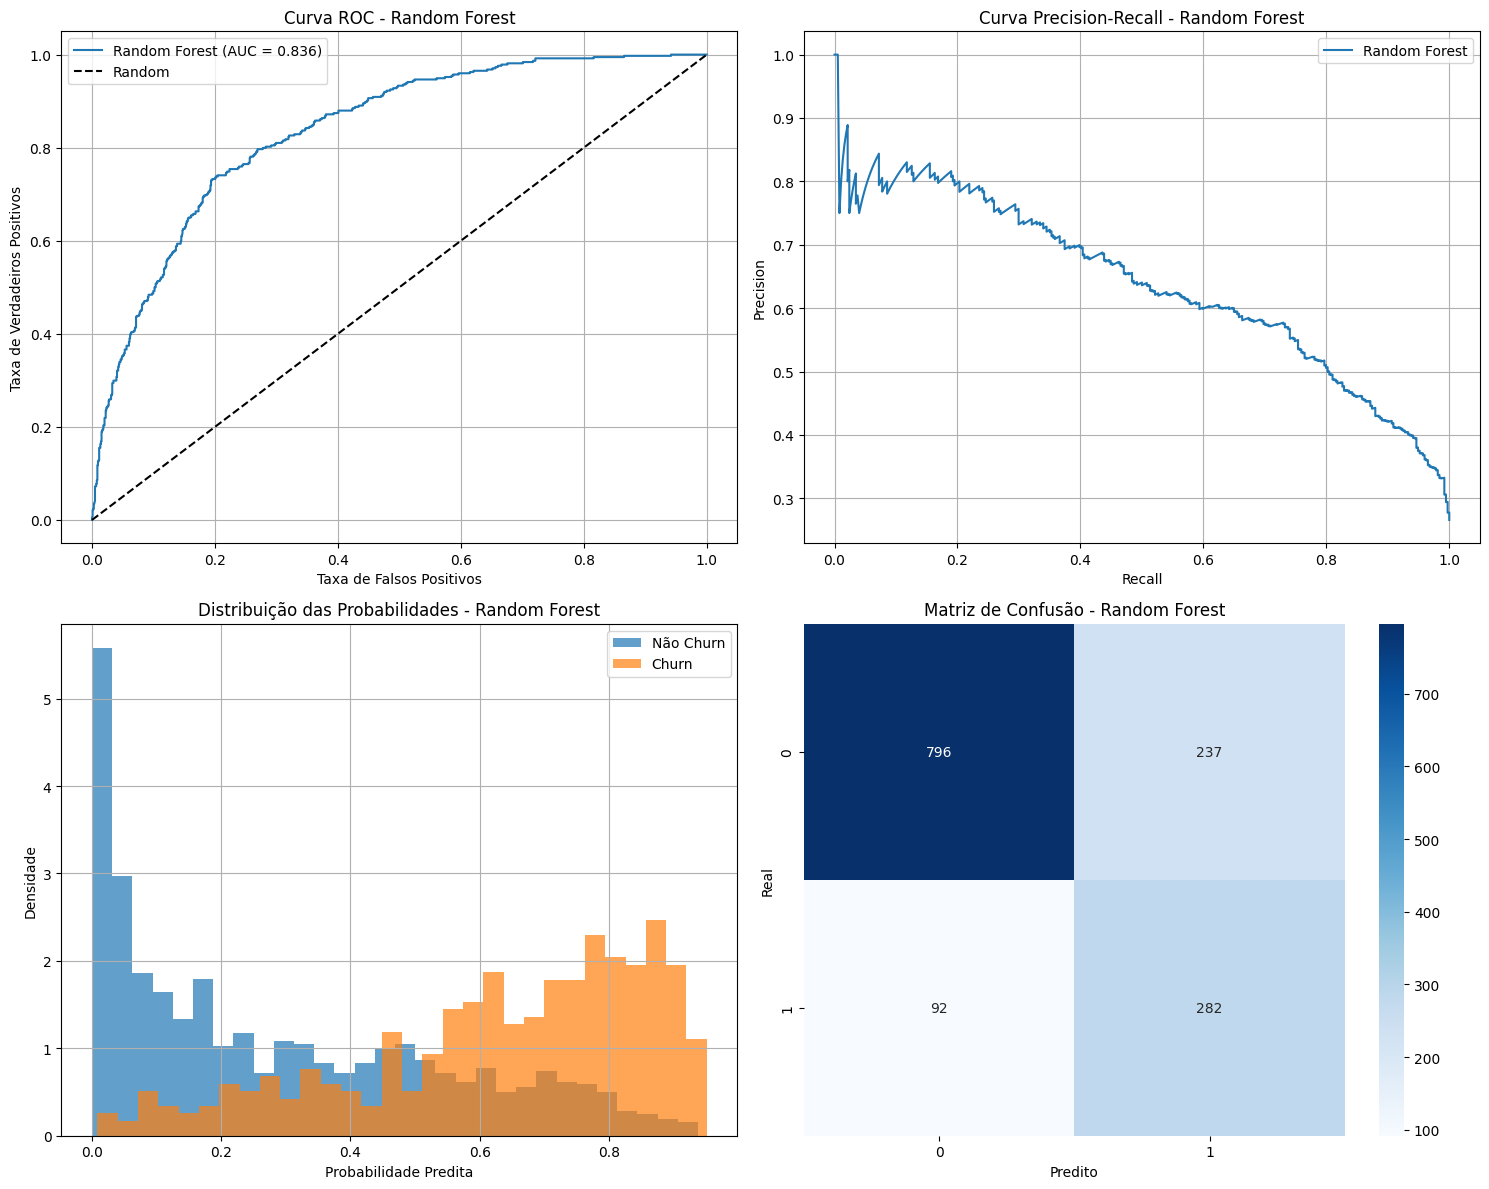


AVALIAÇÃO DO MODELO: XGBoost
Precision: 0.6030
Recall: 0.5321
F1-Score: 0.5653
AUC-ROC: 0.8263
KS Statistic: 0.5015 (p-value: 0.0000)

Matriz de Confusão:
[[902 131]
 [175 199]]

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.84      0.87      0.85      1033
           1       0.60      0.53      0.57       374

    accuracy                           0.78      1407
   macro avg       0.72      0.70      0.71      1407
weighted avg       0.78      0.78      0.78      1407



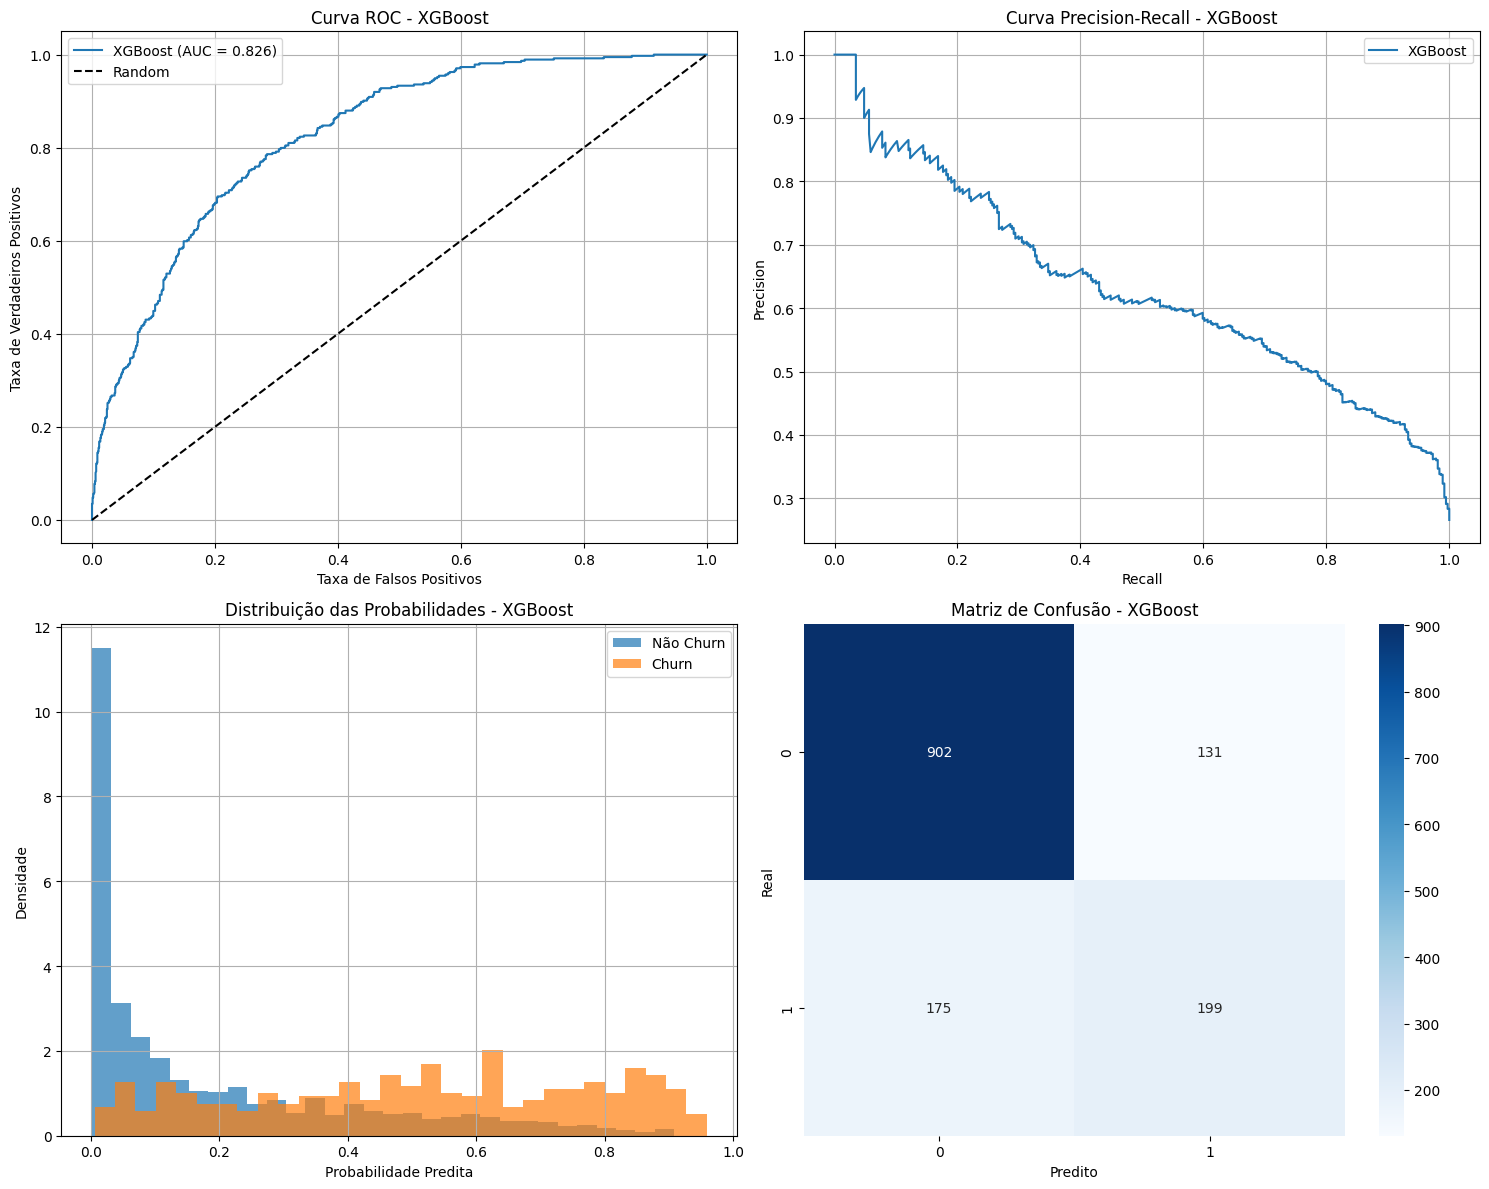


COMPARAÇÃO DOS MODELOS
               precision  recall  f1_score  auc_roc  ks_statistic  ks_p_value
Random Forest     0.5434  0.7540    0.6316   0.8360        0.5371         0.0
XGBoost           0.6030  0.5321    0.5653   0.8263        0.5015         0.0

Melhor modelo baseado no F1-Score: Random Forest

IMPORTÂNCIA DAS FEATURES - Random Forest

Top 10 features mais importantes:
                                 feature  importance
1                                 tenure    0.177125
3                           TotalCharges    0.140192
2                         MonthlyCharges    0.106497
25                     Contract_Two year    0.102315
10           InternetService_Fiber optic    0.064590
28        PaymentMethod_Electronic check    0.053363
24                     Contract_One year    0.044090
13                    OnlineSecurity_Yes    0.038040
19                       TechSupport_Yes    0.024612
16  DeviceProtection_No internet service    0.020160


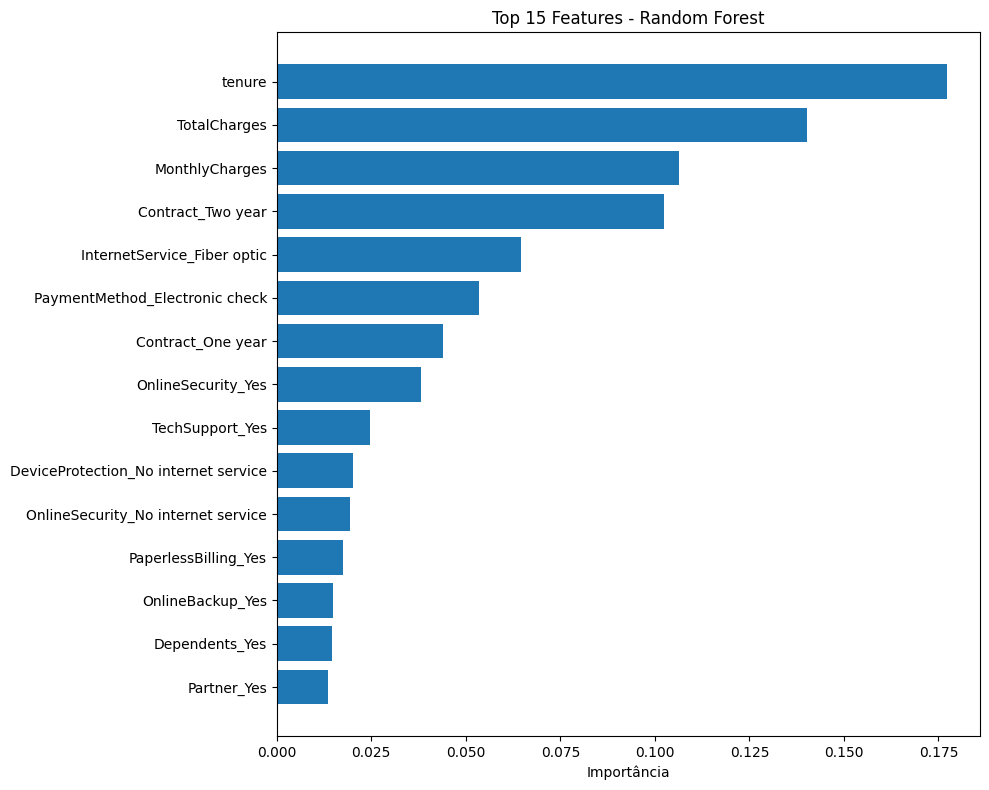


PIPELINE CONCLUÍDO!


In [9]:
if __name__ == "__main__":
    results = main()